# Exercise 2: Separate $t$- and $s$-channel contributions

Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The **electron** Monte Carlo sample incorporate contributions from $t$- and $s$-channels.
* Select/correct contributions producing $Z$ boson decays. (Hint: Which role does the $\cos(\theta)$ distribution play in separating $t$- and $s$-channels?)

#### Import libraries and functions

In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#### Load the relevant data

In [2]:
### Specify the folder path for MC samples
path_data = 'data/'

### Open the file introducing file path
mc_data_ee = uproot.open(path_data+'ee.root')
ttree_name = 'myTTree'

### Print list of 'branches' of the TTree (i.e. list of variable names)
print(mc_data_ee[ttree_name].keys())

### Load branches
branches_ee = mc_data_ee[ttree_name].arrays()

['run', 'event', 'Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'E_lep', 'cos_thru', 'cos_thet']


The last line shows all the variables available in the TTree to carry out the experiment. The meaning of these is described in the following table

| Variable name | Description |
| --- | --- | 
| <pre>run</pre> | Run number |
| <pre>event</pre> | Event number |
| <pre>Ncharged</pre> | Number of charged tracks |
| <pre>Pcharged</pre> | Total scalar sum of track momenta |
| <pre>E_ecal</pre> | Total energy measured in the electromagnetic calorimeter |
| <pre>E_hcal</pre> | Total energy measured in the hadronic calorimete |
| <pre>E_lep</pre> | LEP beam energy (=$\sqrt{s}/2$) |
| <pre>cos_thru</pre> | cosine of the polar angle between beam axis and thrust axis |
| <pre>cos_thet</pre> | cosine of the polar angle between incoming positron and outgoing positive particle |


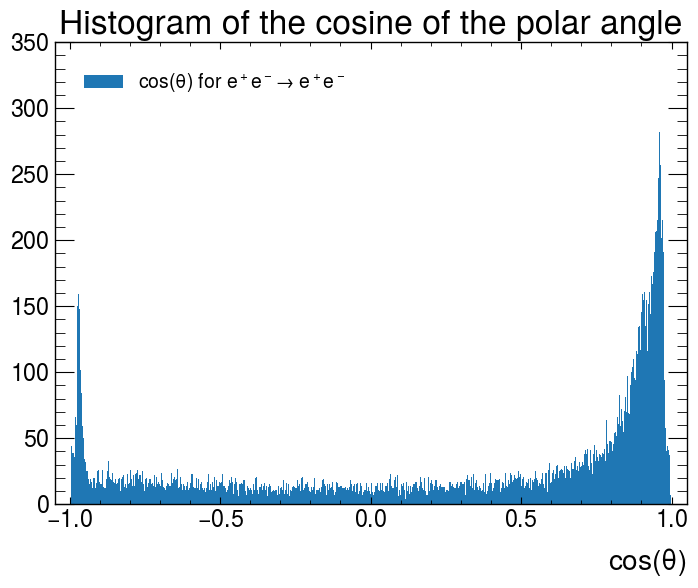

In [3]:
plt.style.use(mplhep.style.ATLAS) # load ATLAS plot style
plt.title(r'Histogram of the cosine of the polar angle')
plt.hist(ak.to_numpy(branches_ee['cos_thet']),bins=np.arange(-1,1,0.001),label=r'$\cos(\theta)$ for $e^+e^- \to \ e^+e^-$')
plt.xlim(-1.05,1.05)
plt.xlabel(r'$\cos(\theta)$')
plt.legend()
plt.show()